# Цель и задание лабораторной работы

**Цель:** изучение вопросов автоматического анализа/синтеза текстов и алгоритмов, которые используются в процессе анализа.

**Задание:**  
1. Подготовить исходные данные, например, в виде файла с сообщениями из Twitter на определенную тематику. 
2. Провести анализ текста, включающий следующие этапы: обработку данных, классификацию текста, с применением меры TF-IDF, технологии Word2Vec, оценить качество классификации.
3. Провести анализ тональности сообщений с использованием нейронных сетей (например, с помощью RNN). Реализовать несколько RNN с различной архитектурой.  
4. Оценить влияние архитектуры RNN на результаты SA, сделать выводы и обосновать их. 
5. Интерпретировать и сравнить полученные результаты. 
6. Ответить на вопросы. 
7. Оформить отчет по лабораторной работе. 

# Анализ текста

## Основные библиотеки для анализа текста

Ниже перечислены необходимые библиотеки для анализа текста

In [1]:
#чтобы не видеть будущие предупреждения
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np 
#для работы с таблицей данных
import pandas as pd 
# NLP 
#регулярные выражения
import re 
#для обработки естественного языка
import nltk 
#стоп-слова: шум, не несут смысловой нагрузки (предлоги, союзы и т.п.)
nltk.download('stopwords') 
nltk.download('wordnet')
from nltk.corpus import stopwords 
#токенизация - разбиения текста на слова
from nltk.tokenize import word_tokenize  
from nltk.tokenize import RegexpTokenizer
#преобразование слов в начальную форму (без суффиксов, окончаний и т.п.)
#стемминг - по сути, усечение окончаний слов
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer 
#лемматизация - приведение слова к нормальной (словарной) форме
from nltk.stem import WordNetLemmatizer 
# Предобработка данных
from sklearn import preprocessing 
from sklearn.utils import class_weight as cw 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer 
#парсинг - автоматический сбор данных
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Анастасия\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Анастасия\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Далее подгружаем данные

Посмотреть данные: [исходные данные](https://www.kaggle.com/columbine/imdb-dataset-sentiment-analysis-in-csv-format)

In [2]:
#загрузка данных
df_test = pd.read_csv("C:/Users/Анастасия/Desktop/lab4/Test.csv", encoding='utf-8')
df_train = pd.read_csv("C:/Users/Анастасия/Desktop/lab4/Train.csv", encoding='utf-8')

## Стандартизация текста

Очищаем и токенизируем текст. Для это воспользуемся следующими функциями: 
- ***WordNetLemmatizer*** - лемматизация - преобразование слова в базовую форму. Мы не пользуемся стеммингом, потому что он просто делает усечение слова, удаляя окончания. Нам это не подходит, т.к. мы хотим сохранить смысл слов. 
- ***RegexpTokenizer*** - токенизация - разбиваем строку на слова, для последующего анализа.

In [3]:
#очистка данных - стандартизация текста
def clean_text(df, text_field):
    df[text_field] = df[text_field].apply(lambda x: BeautifulSoup(x, "lxml").get_text()) 
    #приведение к нижнему регистру
    df[text_field] = df[text_field].apply(lambda x: x.lower()) 
    #удаление знаков пунктуации
    df[text_field] = df[text_field].apply(lambda x: re.sub("[^a-zA-Z]", " ", x)) 
    #удаление табуляции, переноса строки и т.п.
    df[text_field] = df[text_field].apply(lambda x: re.sub("\s+", " ", x)) 
    #удление англ. стоп-слов
    stopwords_ = stopwords.words('english') 
    df[text_field] = df[text_field].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_)]))
    return df

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

def tokkenize(df, text_field):
    df["tokens"] = df[text_field].apply(tokenizer.tokenize)
    return df

def lemmatize(df, text_field):
    df[text_field] = df["tokens"].apply(lambda x: ' '.join([lemmatizer.lemmatize(w, 'v') for w in x]))
    return df

def standart_text(df, text_field):
    df = clean_text(df, text_field)
    df = tokkenize(df, text_field)
    df = lemmatize(df, text_field)
    return df

In [4]:
df_test = standart_text(df_test, "text")
df_train = standart_text(df_train, "text")

Результат стандартизации текста в столбце "tokens":

In [5]:
df_train.head()

,text,label,tokens
0,grow b watch love thunderbirds mat school watc...,0,"[grew, b, watching, loving, thunderbirds, mate..."
1,put movie dvd player sit coke chip expectation...,0,"[put, movie, dvd, player, sat, coke, chips, ex..."
2,people know particular time past like feel nee...,0,"[people, know, particular, time, past, like, f..."
3,even though great interest biblical movies bor...,0,"[even, though, great, interest, biblical, movi..."
4,im die hard dads army fan nothing ever change ...,1,"[im, die, hard, dads, army, fan, nothing, ever..."


Для последующего анализа текста, разобьем выборки на отдельные столбцы.

In [6]:
#разбиение на обучающую и тестовую выборки
X_train = df_train["text"]
Y_train = df_train["label"]
X_test = df_test["text"]
Y_test = df_test["label"]

Проверим, сбалансирована ли выборка.

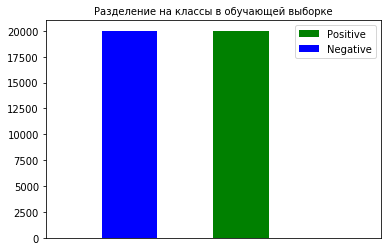

In [17]:
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
#проверка сбалансированности
plt.hist(df_train[df_train.label == 1].label,
         bins=2, color='green', label='Positive')
plt.hist(df_train[df_train.label == 0].label,
         bins=2, color='blue', label='Negative')
plt.title('Разделение на классы в обучающей выборке', fontsize=10)
plt.xticks([])
plt.xlim(-0.5, 2.5)
plt.legend()
plt.show()

Выборка сбалансирована (кол-во позитивных и негативных отзывов примерно одинаково). Значит, можно дальше анализировать текст

## Классификация текста

### Bag of words

Для классификации текста, необходимо составить какую-либо модель. В качестве первой модели (технологии) попробуем Мешок слов ("Bag of words"). 

***Мешок слов*** - это модель текстов, где каждый документ или текст выглядит как неупорядоченный набор слов без сведений о связях между ними. Представляется в виде матрицы, где строка - это документ, столбец - слово. Пересечение - кол-во вхождений слова в данный документ. 

Что нужно сделать для дальнейшей классификации: преобразовать данные в числовой вектор. 

Ниже приведена векторизация для мешка слов.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#векторизация для Мешка слов
def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Визуализируем результаты векторизации. Но! Вектор имеет слишком много координат, поэтому визуализируем по 2-м главным. Для этого используем LSA.

***LSA (скрытый семантический анализ)*** - уменьшает размерность матрицы, полученной после мешка слов (группирует как документы, в которых используются похожие слова, так и слова, которые встречаются в похожем наборе документов).

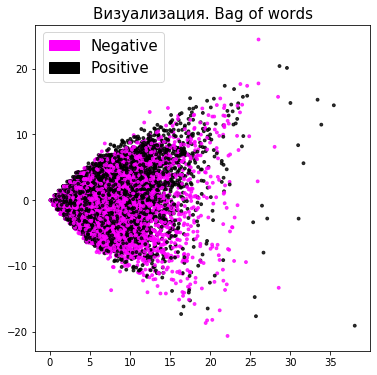

In [27]:
#Визуализация обучающего набора данных

#библиотеки для визуализации
from sklearn.decomposition import PCA, TruncatedSVD

#функция визуализации
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    #уменьшение размерности с использованием усеченного SVD
    #визуализируем по двум компонентам
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['magenta','black']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            n_patch = mpatches.Patch(color='magenta', label='Negative')
            p_patch = mpatches.Patch(color='black', label='Positive')
            plt.legend(handles=[n_patch, p_patch], prop={'size': 15})
            
fig = plt.figure(figsize=(6, 6))          
plot_LSA(X_train_counts, Y_train)
plt.title("Визуализация. Bag of words", fontsize=15)
plt.show()

Выглядит, прямо сказать, не очень. Попробуем воспользоваться логистической регрессией для классификации.

***Логистическая регрессия*** - частный случай линейной регрессии. В данном случае зависимая переменная принимает 2 значения и имеет биномиальное распределение.

По сути, надо построить плоскость, которая разделит пространство на два класса (в нашем случае на позитивные и негативные отзывы).

In [28]:
#используем логистическую регрессию для классификации тестового набора
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, Y_train)
y_predicted_counts = clf.predict(X_test_counts)

Теперь проверим точность классификатора. Для этого посмотрим на следующие параметры:

1. ***precision*** = кол-во правильно положительных / (кол-во правильно положительных + ошибочно положительных).  
*Характеризует долю объектов, названных классификатором положительными, и действительно ими являющиеся.*  
2. ***recall*** = кол-во правильно положительных / (кол-во правильно положительных + ошибочно негативных).  
*Характеризует, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.*
3. ***accuracy*** = (правильно положит. + правильно отрицат.) / всего.  
*Характеризует долю правильных ответов.*

In [29]:
#оценим точность классификатора
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')     
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(Y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.873, precision = 0.873, recall = 0.873, f1 = 0.873


Достаточно хорошая точность в 87%.

Построим ***матрицу ошибок***, чтобы посмотреть, как часто ошибался классификатор.

In [30]:
#посмотрим наглядно, как часто ошибался классификатор
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, y_predicted_counts)
print ('          Negative   Positive')
print('Negative   ', cm[0][0], '     ', cm[0][1])
print('Positive   ', cm[1][0], '     ', cm[1][1])

          Negative   Positive
Negative    2160       335
Positive    302       2203


Как видно, классификатор примерно одинаково точно предсказывает оба класса, поэтому у него достаточно высокая точность.

Теперь посмотрим на список слов (словарь), который использовал классификатор. Рассмотрим первые 10 слов, относящиеся как к негативным, так и к положительным отзывам.

In [31]:
#найдем наиболее часто встречающиеся слова, которые повлияли на классификацию
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

Визуализируем полученные результаты

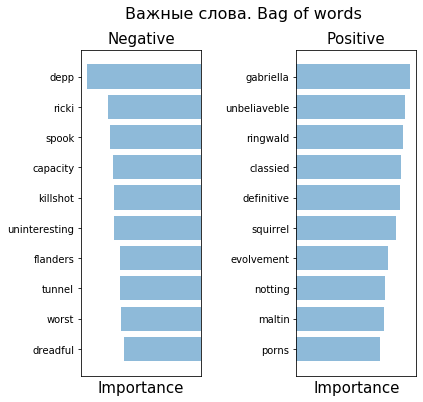

In [43]:
#визуализация часто встречающихся слов
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(6, 6))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=15)
    plt.yticks(y_pos, bottom_words, fontsize=10)
    plt.xticks([])
    plt.suptitle('Key words', fontsize=15)
    plt.xlabel('Importance', fontsize=15)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=15)
    plt.yticks(y_pos, top_words, fontsize=10)
    plt.xticks([])
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=15)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Важные слова. Bag of words")

По результатам можно сказать следующее: наш классификатор обращает внимание на некоторые слова, которые относятся к позитивным отзывам ("unbeliavable" - незабываемый), к отрицательным ("killshot" - убийство, "uninteresting" - неинтересный). Однако, еще достаточно много "мусора".

### TF-IDF

Попробуем другой метод. Применим к мешку слов меру TF-IDF. Она используется для оценки важности слова в контексте документа. Вес слова пропорционален частоте употребления в документе и обратно пропорционален частоте употребления слова во всех документах коллекции. Мера является произведением двух этих весов.

In [44]:
# TF IDF векторизация
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

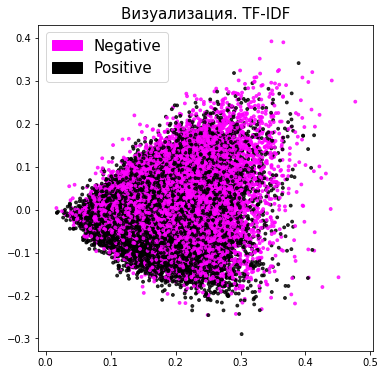

In [45]:
fig = plt.figure(figsize=(6, 6))          
plot_LSA(X_train_tfidf, Y_train)
plt.title("Визуализация. TF-IDF", fontsize=15)
plt.show()

По сравнению с Bag of words разбиение выглядит лучше, хотя всё еще далеко от идеала. Снова используем логистическую регрессию для классификации тестового набора.

In [46]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, Y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [47]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(Y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.891, precision = 0.891, recall = 0.891, f1 = 0.891


Точность повысилась чуть больше чем на 2%. Неплохое улучшение результата.

Теперь опять посмотрим на матрицу ошибок.

In [48]:
cm2 = confusion_matrix(Y_test, y_predicted_tfidf)
print('Матрица ошибок для TF-IDF: \n')
print ('          Negative   Positive')
print('Negative   ', cm2[0][0], '     ', cm2[0][1])
print('Positive   ', cm2[1][0], '     ', cm2[1][1])
print('\n')
print('Матрица ошибок для Bag of words: \n')
print ('          Negative   Positive')
print('Negative   ', cm[0][0], '     ', cm[0][1])
print('Positive   ', cm[1][0], '     ', cm[1][1])

Матрица ошибок для TF-IDF: 

          Negative   Positive
Negative    2199       296
Positive    248       2257


Матрица ошибок для Bag of words: 

          Negative   Positive
Negative    2160       335
Positive    302       2203


Как видно, кол-во ошибок уменьшилось, что и повысилось точность классификатора.

Аналогично посмотрим на наиболее важные слова.

In [49]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

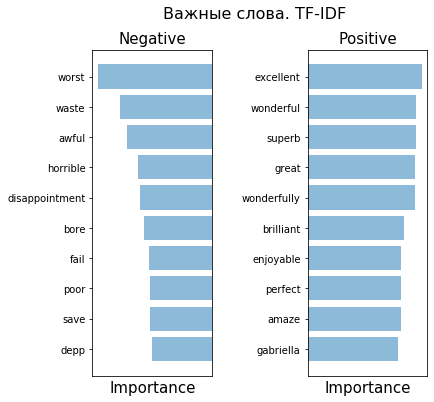

In [50]:
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Важные слова. TF-IDF")

Как видно, произошло значительное улучшение! 

Положительные отзывы теперь характеризуются словами: "excellent" - отличный, "wonderful" - прекрасный, "great" - великолепный и т.д.

Отрицательные отзывы теперь характеризуются словами: "worst" - наихудший, "waste" - потраченный, "horrible" - ужасный и т.д.

### Word2Vec

Перейдем теперь к другой технологии, называемой Word2Vec. Word2Vec - это технология, которая нужна для обработки больших массивов текстовой информации. Она собирает статистику по совместному появлению слов в фразах, после чего методами нейронных сетей решает задачу снижения размерности и выдает на выходе компактные векторные представления слов, в максимальной степени отражающие отношения этих слов в обрабатываемых текстах.

В качестве исходных данных мы выбрали предварительно обученную модель новостей Google (т.к. она содержит миллионы записей).

In [51]:
import gensim

word2vec_path = "C:/Users/Анастасия/Desktop/lab4/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

Самый быстрый способ, получить векторное представление для нашего классификатора, - усреднить значения word2vec, полученные на основе исходных данных, для всех слов из нашего списка.

In [52]:
df_test = tokkenize(df_test, "text")
df_train = tokkenize(df_train, "text")

In [53]:
df_train.head()

,text,label,tokens
0,grow b watch love thunderbirds mat school watc...,0,"[grow, b, watch, love, thunderbirds, mat, scho..."
1,put movie dvd player sit coke chip expectation...,0,"[put, movie, dvd, player, sit, coke, chip, exp..."
2,people know particular time past like feel nee...,0,"[people, know, particular, time, past, like, f..."
3,even though great interest biblical movies bor...,0,"[even, though, great, interest, biblical, movi..."
4,im die hard dads army fan nothing ever change ...,1,"[im, die, hard, dads, army, fan, nothing, ever..."


In [54]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else 
                      np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector 
                      else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, massiv, generate_missing=False):
    embeddings = massiv['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [55]:
#embeddings = get_word2vec_embeddings(word2vec, clean_questions)
embeddings_test = get_word2vec_embeddings(word2vec, df_test)
embeddings_train = get_word2vec_embeddings(word2vec, df_train)

In [56]:
X_train_word2vec = embeddings_train
X_test_word2vec = embeddings_test

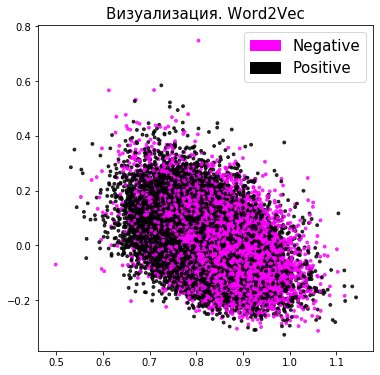

In [57]:
fig = plt.figure(figsize=(6, 6))          
plot_LSA(embeddings_train, Y_train)
plt.title("Визуализация. Word2Vec", fontsize=15)
plt.show()

Как видно из визуализации, классы всё ещё смешаны, но разделены всё же неплохо.

Применим снова логистическую регрессию.

In [58]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, Y_train)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

Оценим точность классификации.

In [59]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(Y_test, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.848, precision = 0.848, recall = 0.848, f1 = 0.848


Точность всего 85%, что даже ниже, чем у простого мешка слов.

Посмотрим на матрицу ошибок и сравним её с предыдущими методами.

In [60]:
cm_w2v = confusion_matrix(Y_test, y_predicted_word2vec)
print('Матрица ошибок для Word2Vec: \n')
print ('          Negative   Positive')
print('Negative   ', cm_w2v[0][0], '     ', cm_w2v[0][1])
print('Positive   ', cm_w2v[1][0], '     ', cm_w2v[1][1])
print('\n')
print('Матрица ошибок для TF-IDF: \n')
print ('          Negative   Positive')
print('Negative   ', cm2[0][0], '     ', cm2[0][1])
print('Positive   ', cm2[1][0], '     ', cm2[1][1])
print('\n')
print('Матрица ошибок для Bag of words: \n')
print ('          Negative   Positive')
print('Negative   ', cm[0][0], '     ', cm[0][1])
print('Positive   ', cm[1][0], '     ', cm[1][1])

Матрица ошибок для Word2Vec: 

          Negative   Positive
Negative    2088       407
Positive    355       2150


Матрица ошибок для TF-IDF: 

          Negative   Positive
Negative    2199       296
Positive    248       2257


Матрица ошибок для Bag of words: 

          Negative   Positive
Negative    2160       335
Positive    302       2203


Как видно из матриц, данный метод имеет худшие результаты из представленных.

В случае Word2Vec нельзя просто увидеть наиболее важные слова для классификации, т.к. он использует комбинации слов. Поэтому нам придется воспользоваться LIME. 

***LIME*** - это метод объяснения предсказания классификатора, который изучает модель и пытается интерпретировать модель.

In [61]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
   
X_train_data = X_train
X_test_data = X_test
y_train_data = Y_train
y_test_data = Y_test
vector_store = word2vec

def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [62]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["Negative","Positive"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [63]:
visualize_one_exp(X_test_data, y_test_data, 65)

Index: 65
True class: Positive


In [64]:
visualize_one_exp(X_test_data, y_test_data, 2)

Index: 2
True class: Negative


Мы получили достаточно хорошую интерпретацю результатов. Посмотрим так же на наиболее важные для классификации слова.

In [65]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Negative',
    1: 'Positive'
}
sorted_contributions = get_statistical_explanation(X_test_data.tolist(), 100, word2vec_pipeline, label_to_text)

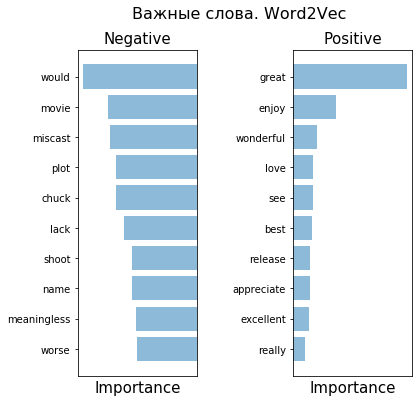

In [66]:
top_words = sorted_contributions['Positive']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Positive']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Positive']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Positive']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Важные слова. Word2Vec")

Из диаграммы выше можно сделать вывод, что позитивные отзывы данный метод предсказывает лучше, чем отрицательные.
И всё же данный метод уступает TF-IDF по точности предсказаний.

### Выводы

1. Самым точным методом для векторизации данных для данного случая является применение меры TF-IDF. При её использовании была достигнута точность в 89%. 

2. Положительные отзывы теперь характеризуются словами: "excellent" - отличный, "wonderful" - прекрасный, "great" - великолепный и т.д.  
Отрицательные отзывы теперь характеризуются словами: "worst" - наихудший, "waste" - потраченный, "horrible" - ужасный и т.д. 

3. Другие методы тоже показали хорошую точность на тестовых данных: Bag of words = 87%, Word2Vec = 85%.